# Import Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from collections import Counter

from tqdm import tqdm
import os

# Read train and test data

In [2]:
train_data = pd.read_csv("train.tsv", sep='\t')
print("Shape of train_data",train_data.shape)
train_data.head(3)

Shape of train_data (1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
test_data = pd.read_csv("test.tsv", sep='\t')
print("Shape of test_data",test_data.shape)
test_data.head(3)

Shape of test_data (693359, 7)


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...


# EDA

# On train_data

In [4]:
train_data.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

In [5]:
train_data.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [6]:
train_data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [7]:
train_data.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [8]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
train_id,1482535.0,741267.000000,427971.135004,0.0,370633.5,741267.0,1111900.5,1482534.0
item_condition_id,1482535.0,1.907380,0.903159,1.0,1.0,2.0,3.0,5.0
price,1482535.0,26.737516,38.586066,0.0,10.0,17.0,29.0,2009.0
shipping,1482535.0,0.447274,0.497212,0.0,0.0,0.0,1.0,1.0


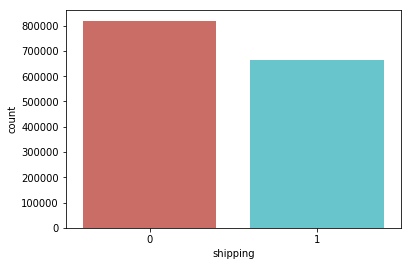

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='shipping',data=train_data, palette='hls')
plt.show()

In [10]:
train_data["item_condition_id"].value_counts()


1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

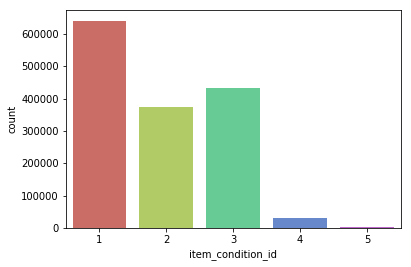

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='item_condition_id',data=train_data, palette='hls')
plt.show()

# Conclusions about train_data

* category_name & brand_name have missing values

* name, item_description, category_name & brand_name are objects



# On test_data

In [12]:
test_data.columns

Index(['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description'],
      dtype='object')

In [13]:
test_data.dtypes

test_id               int64
name                 object
item_condition_id     int64
category_name        object
brand_name           object
shipping              int64
item_description     object
dtype: object

In [14]:
test_data.isnull().sum()

test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64

In [15]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
test_id,693359.0,346679.000000,200155.646984,0.0,173339.5,346679.0,520018.5,693358.0
item_condition_id,693359.0,1.906102,0.903378,1.0,1.0,2.0,3.0,5.0
shipping,693359.0,0.447719,0.497260,0.0,0.0,0.0,1.0,1.0


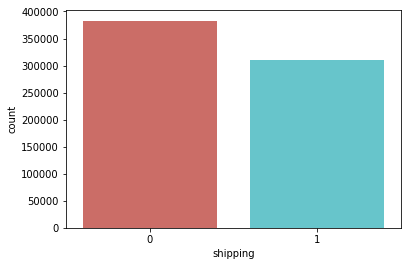

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='shipping',data=test_data, palette='hls')
plt.show()

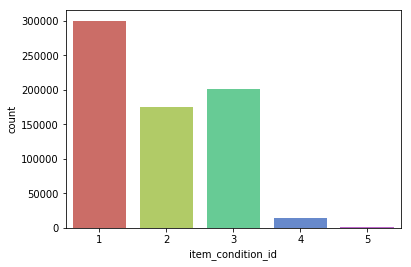

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='item_condition_id',data=test_data, palette='hls')
plt.show()

# Conclusions about test_data

* category_name & brand_name have missing values

* name, item_description, category_name & brand_name are objects



# Imputer Missing values by most frequent 

## Impute category_name

In [18]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(train_data['category_name'].as_matrix().reshape(-1,1))

a2=imp_mean.transform(train_data['category_name'].as_matrix().reshape(-1,1))
b2=imp_mean.transform(test_data['category_name'].as_matrix().reshape(-1,1))

In [19]:
train_data['category_name'] = a2
test_data['category_name'] = b2

## Impute brand_name

In [20]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(train_data['brand_name'].as_matrix().reshape(-1,1))

a3=imp_mean.transform(train_data['brand_name'].as_matrix().reshape(-1,1))
b3=imp_mean.transform(test_data['brand_name'].as_matrix().reshape(-1,1))

In [21]:
train_data['brand_name'] = a3
test_data['brand_name'] = b3

## Impute item_description

In [31]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value = "No description yet")
imp_mean.fit(train_data['item_description'].as_matrix().reshape(-1,1))

a4=imp_mean.transform(train_data['item_description'].as_matrix().reshape(-1,1))
b4=imp_mean.transform(test_data['item_description'].as_matrix().reshape(-1,1))

In [32]:
train_data['item_description'] = a4
test_data['item_description'] = b4

In [35]:
train_data.to_csv("train_data_missing.csv")
test_data.to_csv("test_data_missing.csv")

In [36]:
train_data.head(3) 

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,PINK,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [18]:
train_data = pd.read_csv("train_data_missing.csv")
test_data = pd.read_csv("test_data_missing.csv")
train_data.head(3)

,Unnamed: 0,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,PINK,10.0,1,No description yet
1,1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


# Preprocessing

## Of name

In [19]:
name = list(train_data['name'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

name_list = []
for i in name:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
        temp = temp.replace('-','_')
        temp = temp.replace('+','_')
        
    name_list.append(temp.strip())

train_data['clean_names'] = name_list
train_data.drop(['name'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in train_data['clean_names'].values:
    my_counter.update(word.split())
    
name_dict = dict(my_counter)
sorted_name_dict = dict(sorted(name_dict.items(), key=lambda kv: kv[1]))

print(sorted_name_dict)

train_data.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,Unnamed: 0,train_id,item_condition_id,category_name,brand_name,price,shipping,item_description,clean_names
0,0,0,3,Men/Tops/T-shirts,PINK,10.0,1,No description yet,MLBCincinnatiRedsTShirtSizeXL
1,1,1,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,RazerBlackWidowChromaKeyboard
2,2,2,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,AVA_VIVBlouse
3,3,3,1,Home/Home Décor/Home Décor Accents,PINK,35.0,1,New with tags. Leather horses. Retail for [rm]...,LeatherHorseStatues
4,4,4,1,Women/Jewelry/Necklaces,PINK,44.0,0,Complete with certificate of authenticity,24KGOLDplatedrose


In [22]:
name = list(test_data['name'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

name_list = []
for i in name:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
        temp = temp.replace('"','_')
        temp = temp.replace('-','_')
        temp = temp.replace('+','_')
        
    name_list.append(temp.strip())

test_data['clean_names'] = name_list
test_data.drop(['name'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in test_data['clean_names'].values:
    my_counter.update(word.split())
    
name_dict = dict(my_counter)
sorted_name_dict = dict(sorted(name_dict.items(), key=lambda kv: kv[1]))

print(sorted_name_dict)

test_data.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,Unnamed: 0,test_id,item_condition_id,category_name,brand_name,shipping,item_description,clean_names
0,0,0,1,Women/Jewelry/Rings,PINK,1,Size 7,Breastcancer_Ifightlikeagirl_ring
1,1,1,1,Other/Office supplies/Shipping Supplies,PINK,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",25pcsNEW7.5_x12_KraftBubbleMailers
2,2,2,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Coachbag
3,3,3,2,Women/Sweaters/Cardigan,PINK,0,-floral kimono -never worn -lightweight and pe...,FloralKimono
4,4,4,3,Other/Books/Religion & Spirituality,PINK,1,Rediscovering life after the loss of a loved o...,LifeafterDeath


## Of category_name

In [23]:
category_name = list(train_data['category_name'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

category_name_list = []
for i in category_name:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
        temp = temp.replace('/','_')
        temp = temp.replace('-','_')
        temp = temp.replace('+','_')
        temp = temp.replace("'","")
        
    category_name_list.append(temp.strip())

train_data['clean_category_names'] = category_name_list
train_data.drop(['category_name'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in train_data['clean_category_names'].values:
    my_counter.update(word.split())
    
category_name_dict = dict(my_counter)
sorted_category_name_dict = dict(sorted(category_name_dict.items(), key=lambda kv: kv[1]))

print(sorted_category_name_dict)

train_data.head()

{'Men_Suits_OneButton': 1, 'Handmade_Accessories_Belt': 1, 'Handmade_Geekery_Videogame': 1, 'Handmade_Holidays_Thanksgiving': 1, 'Handmade_Patterns_Painting': 1, 'Handmade_Housewares_Bathroom': 1, 'Handmade_Geekery_Housewares': 1, 'Vintage_Collectibles_Antique_Furniture': 1, 'Handmade_DollsandMiniatures_ChildFriendly': 1, 'Handmade_Toys_DollClothes': 1, 'Vintage_Collectibles_Book_Decorating': 1, 'Home_HomeAppliances_GarbageDisposals': 1, 'Other_Automotive_RVParts_Accessories': 1, 'Handmade_Woodworking_Sculptures': 1, 'Handmade_Others_Educational': 1, 'Handmade_Quilts_Bed': 1, 'Men_Blazers_SportCoats_DoubleBreasted': 1, 'Handmade_Knitting_BagsandPurses': 1, 'Handmade_Needlecraft_Clothing': 1, 'Vintage_Collectibles_Furniture_Storage': 1, 'Handmade_Weddings_SomethingBlue': 1, 'Handmade_Housewares_Cleaning': 1, 'Handmade_CeramicsandPottery_Tiles': 1, 'Handmade_Art_Aceo': 1, 'Handmade_Weddings_Frames': 1, 'Handmade_PaperGoods_Pad': 1, 'Handmade_Woodworking_Accessories': 1, 'Home_KidsHomeSto

,Unnamed: 0,train_id,item_condition_id,brand_name,price,shipping,item_description,clean_names,clean_category_names
0,0,0,3,PINK,10.0,1,No description yet,MLBCincinnatiRedsTShirtSizeXL,Men_Tops_T_shirts
1,1,1,3,Razer,52.0,0,This keyboard is in great condition and works ...,RazerBlackWidowChromaKeyboard,Electronics_Computers_Tablets_Components_Parts
2,2,2,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,AVA_VIVBlouse,Women_Tops_Blouses_Blouse
3,3,3,1,PINK,35.0,1,New with tags. Leather horses. Retail for [rm]...,LeatherHorseStatues,Home_HomeDécor_HomeDécorAccents
4,4,4,1,PINK,44.0,0,Complete with certificate of authenticity,24KGOLDplatedrose,Women_Jewelry_Necklaces


In [24]:
category_name = list(test_data['category_name'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

category_name_list = []
for i in category_name:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
        temp = temp.replace('/','_')
        temp = temp.replace('-','_')
        temp = temp.replace('+','_')
        temp = temp.replace("'","")
        
    category_name_list.append(temp.strip())

test_data['clean_category_names'] = category_name_list
test_data.drop(['category_name'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in test_data['clean_category_names'].values:
    my_counter.update(word.split())
    
category_name_dict = dict(my_counter)
sorted_category_name_dict = dict(sorted(category_name_dict.items(), key=lambda kv: kv[1]))

print(sorted_category_name_dict)

test_data.head()

{'Handmade_Woodworking_Accessories': 1, 'Handmade_Woodworking_Carving': 1, 'Handmade_Pets_Other': 1, 'Handmade_Housewares_Outdoor': 1, 'Other_Automotive_Oils_Fluids': 1, 'Handmade_Furniture_Chair': 1, 'Handmade_Patterns_Beading': 1, 'Kids_Diapering_Washcloths_Towels': 1, 'Vintage_Collectibles_Furniture_Entertainment': 1, 'Home_Furniture_ReplacementParts': 1, 'Handmade_Jewelry_BooksandZines': 1, 'Vintage_Collectibles_Supplies_Zipper': 1, 'Handmade_Woodworking_Burning': 1, 'Vintage_Collectibles_Serving_Pitcher': 1, 'Handmade_Woodworking_Boxes': 1, 'Men_Blazers_SportCoats_DoubleBreasted': 1, 'Handmade_DollsandMiniatures_Fantasy': 1, 'Home_Bath_BathroomFurnitureSets': 1, 'Handmade_DollsandMiniatures_Figurines': 1, 'Vintage_Collectibles_Electronics_Clock': 1, 'Handmade_Patterns_Painting': 1, 'Home_HomeAppliances_Freezers_IceMakers': 1, 'Handmade_BooksandZines_Other': 1, 'Home_HomeAppliances_GarbageDisposals': 1, 'Handmade_CeramicsandPottery_Bowls': 1, 'Handmade_Crochet_BagsandPurses': 1, 'H

,Unnamed: 0,test_id,item_condition_id,brand_name,shipping,item_description,clean_names,clean_category_names
0,0,0,1,PINK,1,Size 7,Breastcancer_Ifightlikeagirl_ring,Women_Jewelry_Rings
1,1,1,1,PINK,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",25pcsNEW7.5_x12_KraftBubbleMailers,Other_Officesupplies_ShippingSupplies
2,2,2,1,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Coachbag,Vintage_Collectibles_BagsandPurses_Handbag
3,3,3,2,PINK,0,-floral kimono -never worn -lightweight and pe...,FloralKimono,Women_Sweaters_Cardigan
4,4,4,3,PINK,1,Rediscovering life after the loss of a loved o...,LifeafterDeath,Other_Books_Religion_Spirituality


## Of brand_name 

In [26]:
category_name = list(train_data['brand_name'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

category_name_list = []
for i in category_name:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
        temp = temp.replace("'","")
        temp = temp.replace('/','_')
        temp = temp.replace('-','_')
        temp = temp.replace('+','_')
        temp = temp.replace("'","")
        
    category_name_list.append(temp.strip())

train_data['clean_brand_names'] = category_name_list
train_data.drop(['brand_name'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in train_data['clean_brand_names'].values:
    my_counter.update(word.split())
    
brand_name_dict = dict(my_counter)
sorted_brand_name_dict = dict(sorted(brand_name_dict.items(), key=lambda kv: kv[1]))

print(sorted_brand_name_dict)

train_data.head()

{'Hoover': 1, 'Tangents': 1, 'TooFacedxKatVonD': 1, 'ModernSoul': 1, 'PerfectEquipment®': 1, 'AnneGeddes': 1, 'Mayoral': 1, 'JamieSadock': 1, 'Masons': 1, 'TEHAMA': 1, 'GoldbergerCo': 1, 'UncleMilton': 1, 'OnlyHearts': 1, 'VivienneVivienneTam': 1, 'Butterfly': 1, 'Valve': 1, 'BenBat': 1, 'Lilu': 1, 'Aurum': 1, 'RogueStatus': 1, 'Sergeants': 1, 'A_E': 1, 'Belltech': 1, 'Excelled': 1, 'HearthsideCollection': 1, 'PlanetEarth': 1, 'AccessoryCollective': 1, 'Buff': 1, 'TagJeans': 1, 'REPORT': 1, 'AmericanRebelBootCompany': 1, 'UmoLorenzo': 1, 'MichaelSimon': 1, 'EnglishFactory': 1, 'UndercoverMama': 1, 'Harmont_Blaine': 1, 'ILOVENEWYORKbyBondNo.9': 1, 'Ninety': 1, 'Belleek': 1, 'crossroads': 1, 'Himalayan': 1, 'PampersBabyFresh': 1, 'HoneydewIntimates': 1, 'MercerStreetStudio': 1, 'Gaggia': 1, 'ThreeSeasonsMaternity': 1, 'Replay': 1, 'Ramones': 1, 'EagleUSA': 1, 'Gimmick': 1, 'Excalibur': 1, 'Swix': 1, 'Pre_Seed': 1, 'Barrons': 1, 'Etro': 1, 'TomJames': 1, 'Lunaire': 1, 'ROOK': 1, 'Mongoose

,Unnamed: 0,train_id,item_condition_id,price,shipping,item_description,clean_names,clean_category_names,clean_brand_names
0,0,0,3,10.0,1,No description yet,MLBCincinnatiRedsTShirtSizeXL,Men_Tops_T_shirts,PINK
1,1,1,3,52.0,0,This keyboard is in great condition and works ...,RazerBlackWidowChromaKeyboard,Electronics_Computers_Tablets_Components_Parts,Razer
2,2,2,1,10.0,1,Adorable top with a hint of lace and a key hol...,AVA_VIVBlouse,Women_Tops_Blouses_Blouse,Target
3,3,3,1,35.0,1,New with tags. Leather horses. Retail for [rm]...,LeatherHorseStatues,Home_HomeDécor_HomeDécorAccents,PINK
4,4,4,1,44.0,0,Complete with certificate of authenticity,24KGOLDplatedrose,Women_Jewelry_Necklaces,PINK


In [27]:
category_name = list(train_data['clean_brand_names'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

category_name_list = []
for i in category_name:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
        temp = temp.replace("'","")
        temp = temp.replace('/','_')
        temp = temp.replace('-','_')
        temp = temp.replace('+','_')
        temp = temp.replace("'","")
        
    category_name_list.append(temp.strip())

train_data['clean_brand_names'] = category_name_list




train_data.head()

,Unnamed: 0,train_id,item_condition_id,price,shipping,item_description,clean_names,clean_category_names,clean_brand_names
0,0,0,3,10.0,1,No description yet,MLBCincinnatiRedsTShirtSizeXL,Men_Tops_T_shirts,PINK
1,1,1,3,52.0,0,This keyboard is in great condition and works ...,RazerBlackWidowChromaKeyboard,Electronics_Computers_Tablets_Components_Parts,Razer
2,2,2,1,10.0,1,Adorable top with a hint of lace and a key hol...,AVA_VIVBlouse,Women_Tops_Blouses_Blouse,Target
3,3,3,1,35.0,1,New with tags. Leather horses. Retail for [rm]...,LeatherHorseStatues,Home_HomeDécor_HomeDécorAccents,PINK
4,4,4,1,44.0,0,Complete with certificate of authenticity,24KGOLDplatedrose,Women_Jewelry_Necklaces,PINK


In [43]:
category_name = list(test_data['brand_name'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

category_name_list = []
for i in category_name:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
        temp = temp.replace("'","")
        temp = temp.replace('/','_')
        temp = temp.replace('-','_')
        temp = temp.replace('+','_')
        temp = temp.replace("'","")
        
    category_name_list.append(temp.strip())

test_data['clean_brand_names'] = category_name_list
test_data.drop(['brand_name'], axis=1, inplace=True)



test_data.head()

,Unnamed: 0,test_id,item_condition_id,shipping,clean_names,clean_category_names,cleaned_item_description,clean_brand_names
0,0,0,1,1,Breastcancer_Ifightlikeagirl_ring,Women_Jewelry_Rings,size 7,PINK
1,1,1,1,1,25pcsNEW7.5_x12_KraftBubbleMailers,Other_Officesupplies_ShippingSupplies,25 pcs new 7 5 x12 kraft bubble mailers lined ...,PINK
2,2,2,1,1,Coachbag,Vintage_Collectibles_BagsandPurses_Handbag,brand new coach bag bought rm coach outlet,Coach
3,3,3,2,0,FloralKimono,Women_Sweaters_Cardigan,floral kimono never worn lightweight perfect h...,PINK
4,4,4,3,1,LifeafterDeath,Other_Books_Religion_Spirituality,rediscovering life loss loved one tony cooke p...,PINK


## Of item_description

In [28]:
# printing some random reviews
print(train_data['item_description'].values[0])
print("="*50)
print(train_data['item_description'].values[150])
print("="*50)
print(train_data['item_description'].values[1000])
print("="*50)
print(train_data['item_description'].values[2000])
print("="*50)
print(train_data['item_description'].values[3000])


No description yet
Your ever-faithful companion, the Kate Spade New York® Cobble Hill Mylie shoulder bag embodies form and function like no other. Made of pebbled leather Top zip closure Flat shoulder/elbow strap Removable and adjustable crossbody strap Foil-stamped brand name and hardware spade logo Rear exterior zip pocket Flat base to provide upright structure Custom woven Bookstripe Print on Poly Twill interior lining Interior features one back-wall zip pocket Imported Bottom Width: 11 1⁄2 "*Depth: 4 1⁄4 "*Height: 9 " Strap Length: 41 1⁄2 " Strap Drop: 21" Handle Length: 21 " Handle Drop: 9 "
Gift card for sephora has 25 dollars on it Have no use for it got it as a Christmas gift and I don't like that store tbh When purchased I can either ship you the card or just give you the information if you want to use it online buyers choice
Aspen multi colored Warmer new with box Tahiti pear 1 Paradise pineapple 1
FREE FAST SHIPPING EXTRA FREE☆☆ BEAUTY GIFTS:)¡¡♡♡☆☆☆ Extra free skincare gift

In [29]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [30]:
sent = decontracted(train_data['item_description'].values[150])
print(sent)
print("="*50)

Your ever-faithful companion, the Kate Spade New York® Cobble Hill Mylie shoulder bag embodies form and function like no other. Made of pebbled leather Top zip closure Flat shoulder/elbow strap Removable and adjustable crossbody strap Foil-stamped brand name and hardware spade logo Rear exterior zip pocket Flat base to provide upright structure Custom woven Bookstripe Print on Poly Twill interior lining Interior features one back-wall zip pocket Imported Bottom Width: 11 1⁄2 "*Depth: 4 1⁄4 "*Height: 9 " Strap Length: 41 1⁄2 " Strap Drop: 21" Handle Length: 21 " Handle Drop: 9 "


In [31]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Your ever-faithful companion, the Kate Spade New York® Cobble Hill Mylie shoulder bag embodies form and function like no other. Made of pebbled leather Top zip closure Flat shoulder/elbow strap Removable and adjustable crossbody strap Foil-stamped brand name and hardware spade logo Rear exterior zip pocket Flat base to provide upright structure Custom woven Bookstripe Print on Poly Twill interior lining Interior features one back-wall zip pocket Imported Bottom Width: 11 1⁄2 "*Depth: 4 1⁄4 "*Height: 9 " Strap Length: 41 1⁄2 " Strap Drop: 21" Handle Length: 21 " Handle Drop: 9 "


In [32]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Your ever faithful companion the Kate Spade New York Cobble Hill Mylie shoulder bag embodies form and function like no other Made of pebbled leather Top zip closure Flat shoulder elbow strap Removable and adjustable crossbody strap Foil stamped brand name and hardware spade logo Rear exterior zip pocket Flat base to provide upright structure Custom woven Bookstripe Print on Poly Twill interior lining Interior features one back wall zip pocket Imported Bottom Width 11 1 2 Depth 4 1 4 Height 9 Strap Length 41 1 2 Strap Drop 21 Handle Length 21 Handle Drop 9 


In [33]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [34]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_item_description = []
# tqdm is for printing the status bar
for sentance in tqdm(train_data['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_item_description.append(sent.lower().strip())

100%|██████████| 1482535/1482535 [01:30<00:00, 16417.04it/s]


In [35]:
# Merging preprocessed_essays in project_data

train_data['cleaned_item_description'] = preprocessed_item_description

train_data.head(3)

,Unnamed: 0,train_id,item_condition_id,price,shipping,item_description,clean_names,clean_category_names,clean_brand_names,cleaned_item_description
0,0,0,3,10.0,1,No description yet,MLBCincinnatiRedsTShirtSizeXL,Men_Tops_T_shirts,PINK,no description yet
1,1,1,3,52.0,0,This keyboard is in great condition and works ...,RazerBlackWidowChromaKeyboard,Electronics_Computers_Tablets_Components_Parts,Razer,this keyboard great condition works like came ...
2,2,2,1,10.0,1,Adorable top with a hint of lace and a key hol...,AVA_VIVBlouse,Women_Tops_Blouses_Blouse,Target,adorable top hint lace key hole back the pale ...


In [36]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_item_description = []
# tqdm is for printing the status bar
for sentance in tqdm(test_data['item_description'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_item_description.append(sent.lower().strip())

100%|██████████| 693359/693359 [00:41<00:00, 16688.98it/s]


In [37]:
# Merging preprocessed_essays in project_data

test_data['cleaned_item_description'] = preprocessed_item_description

test_data.head(3)

,Unnamed: 0,test_id,item_condition_id,brand_name,shipping,item_description,clean_names,clean_category_names,cleaned_item_description
0,0,0,1,PINK,1,Size 7,Breastcancer_Ifightlikeagirl_ring,Women_Jewelry_Rings,size 7
1,1,1,1,PINK,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",25pcsNEW7.5_x12_KraftBubbleMailers,Other_Officesupplies_ShippingSupplies,25 pcs new 7 5 x12 kraft bubble mailers lined ...
2,2,2,1,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Coachbag,Vintage_Collectibles_BagsandPurses_Handbag,brand new coach bag bought rm coach outlet


In [38]:
train_data.drop(columns = 'item_description',inplace = True)
test_data.drop(columns = 'item_description',inplace = True)
train_data.head(3)

,Unnamed: 0,train_id,item_condition_id,price,shipping,clean_names,clean_category_names,clean_brand_names,cleaned_item_description
0,0,0,3,10.0,1,MLBCincinnatiRedsTShirtSizeXL,Men_Tops_T_shirts,PINK,no description yet
1,1,1,3,52.0,0,RazerBlackWidowChromaKeyboard,Electronics_Computers_Tablets_Components_Parts,Razer,this keyboard great condition works like came ...
2,2,2,1,10.0,1,AVA_VIVBlouse,Women_Tops_Blouses_Blouse,Target,adorable top hint lace key hole back the pale ...


# Save files in hdf format

In [54]:
train_data.to_hdf("train_data_preprocessed.h5",key="train")
test_data.to_hdf("test_data_preprocessed.h5",key="test")

#                                          END OF NOTEBOOK 